In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Functions

In [2]:
def clean_data(raw, z_threshold=2.5, min_listen_time=20):
    """
    Drops entries with abnormal listening_time (z-score too high or time too low).
    Also removes entries with unknown origin
    :param min_listen_time: entries where the user has listened for less than this (s) are dropped
    :param z_threshold: maximum z-score allowed in the dataset
    :param raw: raw data to be processed
    :return: clean dataset (pd.DataFrame)
    """
    print("Computing z-score...")
    z = np.abs(stats.zscore(raw["listening_time"]))

    print("Cleaning...")
    # Entries with a z-score above the threshold will be dropped (also instant-skips of listening_time < X)
    raw.drop(raw[z > z_threshold].index, inplace=True)
    raw.drop(raw[raw.listening_time < min_listen_time].index, inplace=True)
    return raw[(raw["origin"] != "unknown")]

In [3]:
def is_reco(origin):
    return origin[:3] == "rec" or origin == "flow"

In [4]:
def bin_artists(data, bin_amnt=25, separate_reco=True):
    """
    takes in raw data from streams (with added art_id -- see "formatting/add_artists.py") and bins artists together
    according to their "mainstream" status -- i.e. how much they are listened to.
    :param bin_amnt: amount of bins the artists will be put into AT MOST
    :param separate_reco: Whether or not to add a "recommended" column to the DF
    :param data: DataFrame ["user_id", "ts", "sng_id", "album_id", "listening_time", "listen_type", "origin", "art_id"]
    :return: the same DataFrame with added columns [..., "bin_nb", "recommended"] -- unless recommended is not wanted
    """
    print("Counting artist occurences...")
    artist_count = data["art_id"].value_counts(normalize=False).sort_values(ascending=True).to_frame() \
        .reset_index().rename(columns={"index": "art_id", "art_id": "plays"})
    artist_count["cumplays"] = artist_count["plays"].cumsum()

    print("Binning artists...")
    # Cutting into bin_amnt bins (duplicate bins allowed -- and necessary for small datasets and large amount of bins)
    artist_count["bin"] = pd.cut(artist_count["cumplays"], bin_amnt, duplicates="drop")
    print(f"Number of artists per bin: \n{artist_count.groupby('bin').size()}")

    # Assigning corresponding numbers to bins
    artist_count["bin_nb"] = (artist_count["bin"].cat.codes + 1).values
    print(f"Artists binned into {artist_count['bin_nb'].max()} categories.")

    data = data.merge(artist_count[["art_id", "bin_nb"]], left_on="art_id", right_on="art_id")

    # Adding 'recommended' column
    if separate_reco:
        data["recommended"] = data["origin"].map(is_reco)

    return data

In [5]:
def get_user_frame(data, bin_distribution):
    # Vectorized computing of the users' bin ratios
    user_frame = main_dist.to_frame()
    user_frame.columns = ["ratio"]

    # Our user_frame ends up with [user, bin_nb, ratio] 
    user_plays = user_frame["ratio"].sum(level=0)
    user_frame = user_frame.unstack('bin_nb').divide(bin_distrib, level=1).divide(user_plays, axis=0).stack("bin_nb")

    user_frame = user_frame.reset_index()
    
    return user_frame

In [6]:
FILE_NAME = "../../data/artist_streams.csv"
SAVE_NAME = "../../data/mainstream_data.csv"
MIN_OBS = 100
SEPARATE_RECO = False
BIN_AMNT = 4

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [7]:
print("Reading data...")
raw_data = pd.read_csv(FILE_NAME)
raw_data = clean_data(raw_data, z_threshold=3)
print(f"Data shape: {raw_data.shape[0]} lines, {raw_data.shape[1]} columns")

Reading data...
Computing z-score...
Cleaning...
Data shape: 1368080 lines, 8 columns


In [8]:
# Bin artists together
artist_data = bin_artists(raw_data, BIN_AMNT, SEPARATE_RECO)

print(f"Standard deviation of amount of plays per bin: {np.std(artist_data.groupby(['bin_nb']).size().values)}")

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-1367.079, 342020.75]     7679
(342020.75, 684040.5]       437
(684040.5, 1026060.25]      135
(1026060.25, 1368080.0]      44
dtype: int64
Artists binned into 4 categories.
Standard deviation of amount of plays per bin: 584.0530797795693


In [9]:
 # Occurences of music plays in each bin
bin_distrib = artist_data.groupby("bin_nb").size()

# Reversing bin numbers -- just a dirty little workaround to have the "mainstreamest" bin be 1
artist_data["bin_nb"] = BIN_AMNT+1 - artist_data["bin_nb"]

# Normalized
bin_distrib /= bin_distrib.sum()

In [10]:
# Grouping users and their artist bin consumption
main_dist = artist_data.groupby(["user_id", "recommended", "bin_nb"] if SEPARATE_RECO
                                else ["user_id", "bin_nb"]).size()

print(f"Removing users with fewer than {MIN_OBS} observations...")
remove_idx = artist_data.groupby(["user_id"]).size()
remove_idx = remove_idx[remove_idx < MIN_OBS].index.unique()

main_dist.drop(labels=remove_idx, inplace=True)
print(f"Removed {len(remove_idx)} users.")

Removing users with fewer than 100 observations...
Removed 9 users.


In [11]:
print("Analyzing users...")
test_users = np.random.choice(main_dist.index.get_level_values("user_id").unique(), 6, replace=False)
recommended_choices = [True, False]
aggregate = pd.DataFrame(columns=["user_id", "recommended", "bin_nb", "ratio"])

Analyzing users...


# Users pre-binning based on recommendation usage

In [12]:
# Determining rate of recommended to organic for users
artist_data["recommended"] = artist_data["origin"].map(is_reco)
users_reco = artist_data.groupby(["user_id", "recommended"]).size().reset_index()
users_reco.columns = ["user_id", "recommended", "amnt"]

# Checking if all users have both types before division
users_reco_types = users_reco.groupby(["user_id"]).size()
users_reco_types = list(users_reco_types[users_reco_types == 1].index)

# Adding True column for False-only users and vice-versa
to_add = users_reco[users_reco["user_id"].isin(users_reco_types)]
to_add.loc[:, "recommended"] = ~to_add["recommended"]
# Not using 0 to avoid divisions -- in practice, this won't affect the bins
to_add.loc[:, "amnt"] = 1
users_reco = users_reco.append(to_add).sort_values(by=["user_id"])

users_reco.loc[:, "rate"] = 0
rec_amnts = users_reco[users_reco["recommended"] == True]["amnt"].values
org_amnts = users_reco[users_reco["recommended"] == False]["amnt"].values

# Changing users_reco into the final DataFrame
users_reco = users_reco[users_reco.recommended == True].drop(["recommended", "amnt"], axis=1)
users_reco.loc[:, "rate"] = rec_amnts / (rec_amnts + org_amnts)
print(users_reco)

                                       user_id      rate
1     00877d231a1d10859eefd4288ecc493fd1ea3589  0.456532
3     018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e  0.179395
5     01d78f7619786f5f06843b5f1cb7d7b15a934731  0.003861
7     0282983996af7f6b2a27cfff67fc8982619561d6  0.173289
9     02eae2623eaf23461bbadd9c4f3ae1f659a90809  0.117953
...                                        ...       ...
1958  fe22a3978a595c3a63cb40558db7804956f8e1d7  0.017857
1960  fe8b03dc9d448192808c8cd2bf76657b7562b3ae  0.006729
1962  fea927761d221701b2bf1b6acc2de6d91d060071  0.004255
1964  ff7672529f1387bf35e1296f79009275287980a8  0.004113
1965  ff82befb6c2bcf11c638706bc27cf787128426de  0.002469

[1022 rows x 2 columns]


c:\users\quentin\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


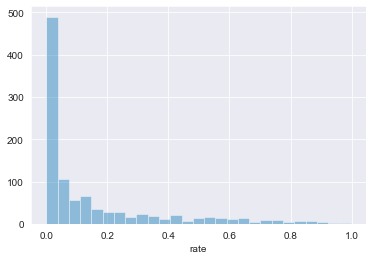

In [13]:
# Distribution of users according to their usage of the recommendation features
sns.distplot(users_reco["rate"], kde=False)

In [14]:
USER_BINS = 4
# Cutting into bins
users_reco["u_bin"] = pd.qcut(users_reco["rate"], USER_BINS, duplicates="drop")
print(f"Number of users per bin: \n{users_reco.groupby('u_bin').size()}")

# Assigning corresponding numbers to bins
users_reco["u_bin_nb"] = (users_reco["u_bin"].cat.codes + 1).values
print(f"Users binned into {users_reco['u_bin_nb'].max()} categories.")
users_reco.drop(["u_bin", "rate"], axis=1, inplace=True)

# sns.distplot(users_reco[users_reco["bin_nb"] == 4]["rate"], kde=False)

Number of users per bin: 
u_bin
(-0.000786, 0.00845]    256
(0.00845, 0.0438]       255
(0.0438, 0.201]         255
(0.201, 0.997]          256
dtype: int64
Users binned into 4 categories.


In [60]:
user_frame = get_user_frame(main_dist, bin_distrib).merge(users_reco, left_on="user_id", right_on="user_id").drop(["user_id"], axis=1)

# Geometric mean
# user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(stats.gmean).to_frame().reset_index()
user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(np.mean).to_frame().reset_index()

print(user_bin_ratios.groupby("u_bin_nb")["ratio"].sum().values.mean())

4.013739279165849


In [63]:
# Testing correctness of user frame ratios
user_frame = get_user_frame(main_dist, bin_distrib)
user_frame.groupby("user_id")["ratio"].sum().values.mean()

array([3.99990267, 4.000594  , 4.00134075, ..., 4.00406564, 4.00187516,
       4.00229168])

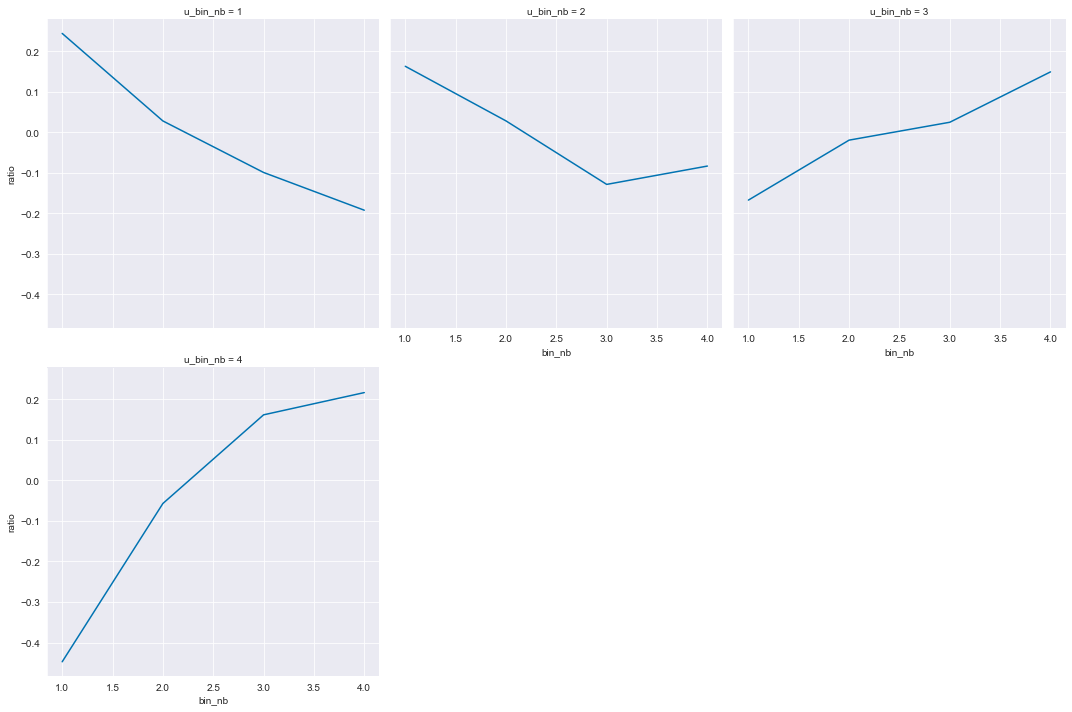

In [62]:
# Log ratio
user_bin_ratios["ratio"] = user_bin_ratios["ratio"].map(np.log)

#Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="u_bin_nb", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_bin_ratios, legend=False)

# Computing bin_distrib -- Vectorized version

In [185]:
user_frame = get_user_frame(main_dist, bin_distrib)

In [186]:
# Saving frame
user_frame.to_csv("mainstream_ratios.csv", index=False)

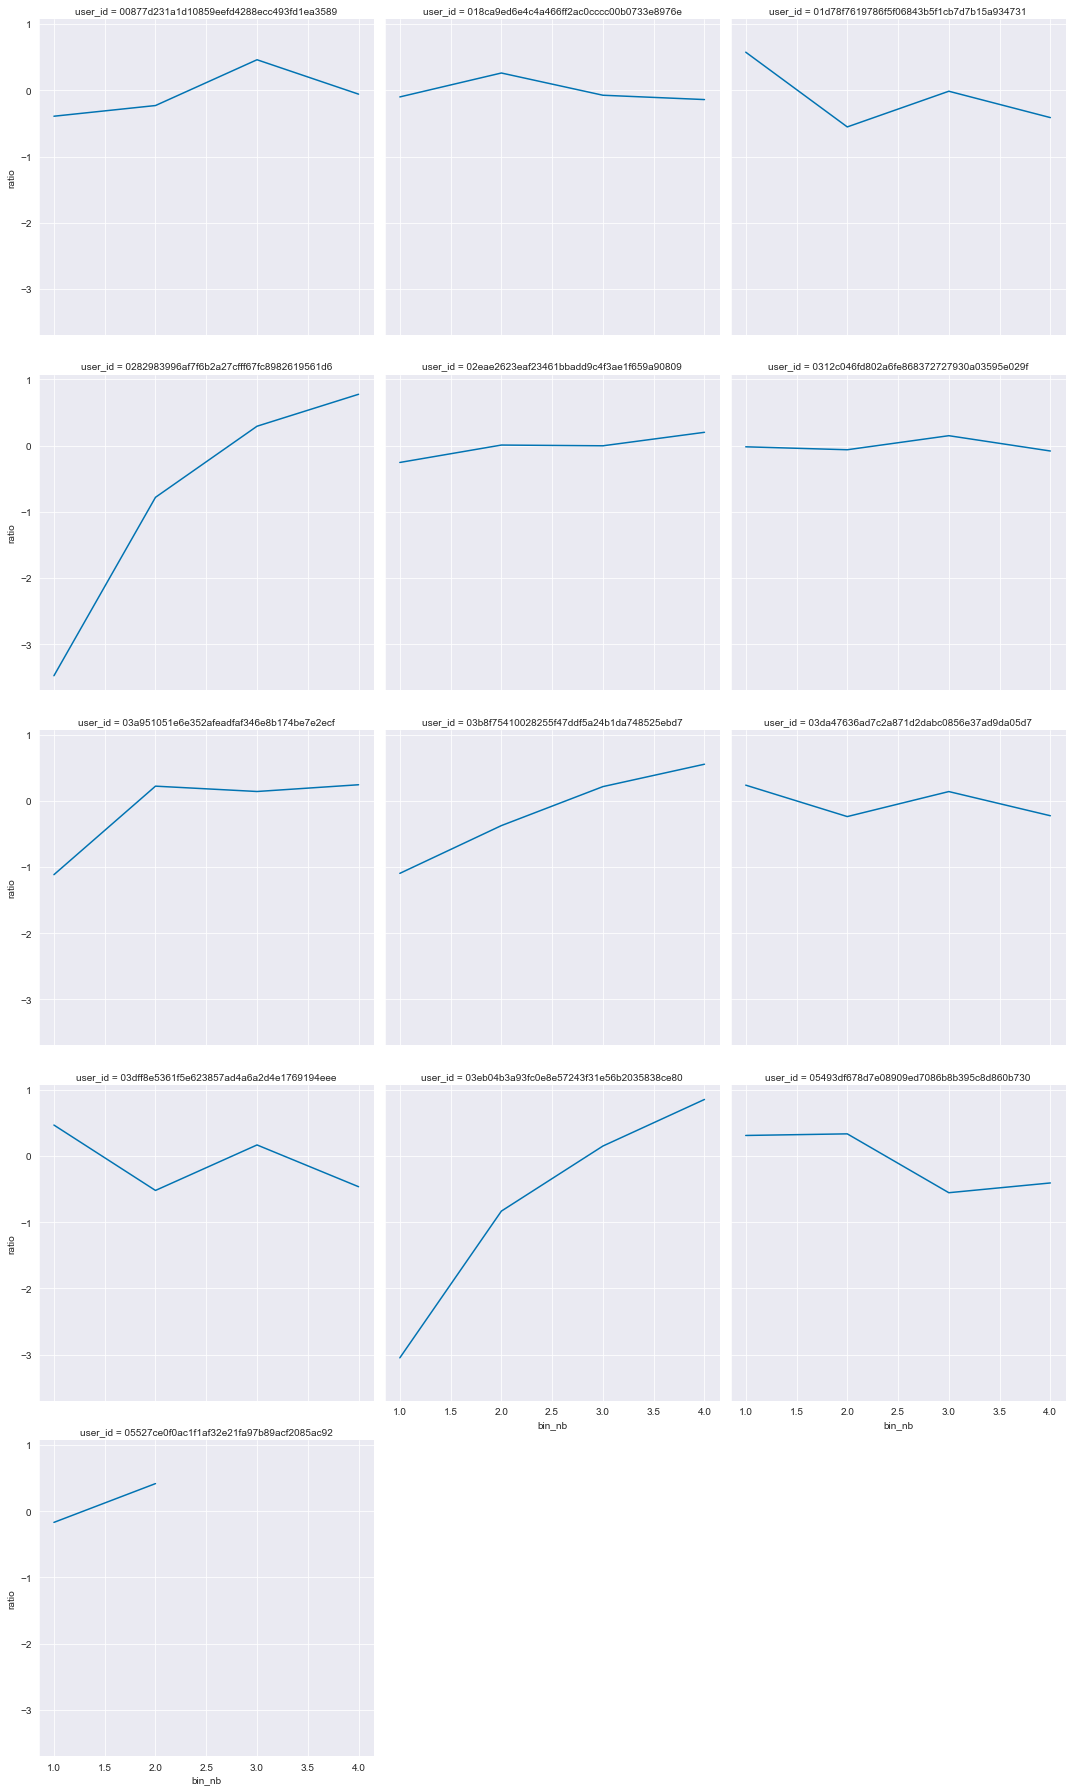

In [187]:
# Log for ratio
user_frame["ratio"] = user_frame["ratio"].map(np.log)

#Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_frame[:50], legend=False)

# Are recommendations favorizing mainstream content?

In [19]:
reco_mainstream = artist_data.merge(users_reco, left_on="user_id", right_on="user_id").drop(["ts", "listen_type", "listening_time", "album_id", "sng_id", "origin"], axis=1)

# For each user bin (recommendation based grouping)
reco_mainstream = reco_mainstream.groupby(["bin_nb", "u_bin_nb", "recommended"]).size()
reco_mainstream = reco_mainstream.to_frame().reset_index()
reco_mainstream.columns = ["bin_nb", "u_bin_nb", "recommended", "amount"]

# Testing stuff right there -- loop version because I have no idea how to vectorize this for now
test = reco_mainstream.groupby(["u_bin_nb", "recommended"]).mean().reset_index()

reco_mainstream["amount"] = reco_mainstream["amount"].astype(float)

for i, row in reco_mainstream.iterrows():
    reco_mainstream.at[i, "amount"] /= test[(test["u_bin_nb"] == reco_mainstream.at[i, "u_bin_nb"]) & (test["recommended"] == reco_mainstream.at[i, "recommended"])]["amount"]
    
reco_mainstream

,bin_nb,u_bin_nb,recommended,amount
0,1,1,False,1.325011
1,1,1,True,0.856566
2,1,2,False,1.205296
3,1,2,True,0.777634
4,1,3,False,0.944249
5,1,3,True,0.635548
6,1,4,False,0.793844
7,1,4,True,0.451694
8,2,1,False,1.040670
9,2,1,True,0.985859


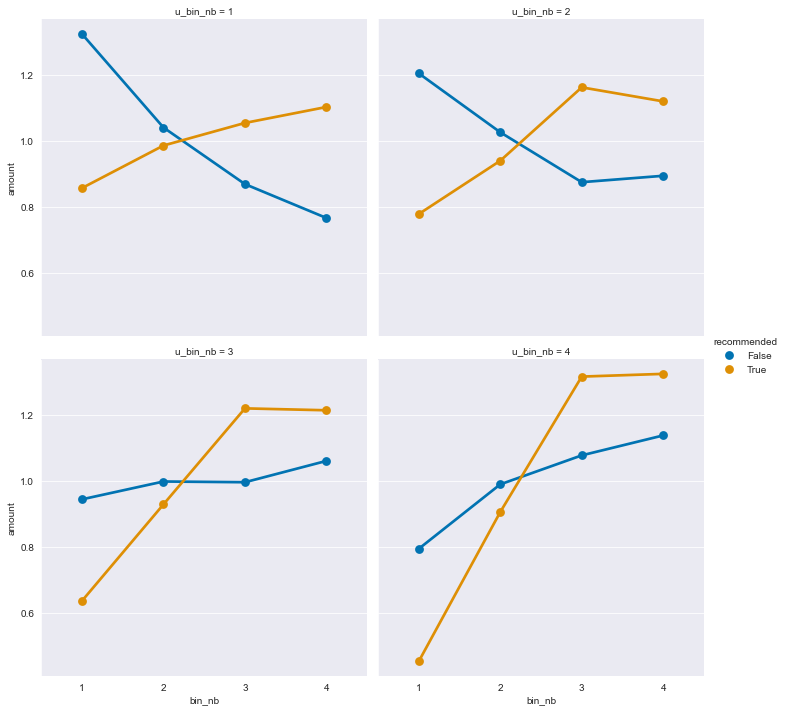

In [16]:
sns.catplot(x="bin_nb", y="amount", col="u_bin_nb", col_wrap=2, hue="recommended", kind="point", data=reco_mainstream)

In [17]:
# Mean mainstream bin for recommended vs. organic
test = reco_mainstream.groupby(["bin_nb", "recommended"])["amount"].sum().to_frame().reset_index()
print(test)
test_org = test[test["recommended"] == False]
test_rec = test[test["recommended"] == True]
print(f'Mean mainstream bin for organic plays: {(test_org["amount"] * test_org["bin_nb"]).sum() / test_org["amount"].sum()}')
print(f'Mean mainstream bin for recommended plays: {(test_rec["amount"] * test_rec["bin_nb"]).sum() / test_rec["amount"].sum()}')

   bin_nb  recommended    amount
0       1        False  4.268400
1       1         True  2.721442
2       2        False  4.055129
3       2         True  3.759940
4       3        False  3.817263
5       3         True  4.755157
6       4        False  3.859208
7       4         True  4.763461
Mean mainstream bin for organic plays: 2.4542050340179307
Mean mainstream bin for recommended plays: 2.7225398871310675


## Are organic non-mainstream listenings the result of previous recommendations?

In [45]:
# Finding songs for each user that were listened to only once 
single_listens = artist_data.groupby(["user_id", "sng_id"]).size()
single_listens = single_listens[single_listens < 2].to_frame().index

data_no_singletons = artist_data[~pd.Series(list(zip(artist_data['user_id'], artist_data['sng_id']))).isin(single_listens)]
data_no_singletons


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id,bin_nb,recommended
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599,2,False
1,b26ce863e9161cc7e36cdf254927457cc5ceb55b,1471320765,121710324,12721422,203,MOD,page_playlist,249599,2,False
2,206929899c1bfc3c49174d20824ab1dc77758567,1471355821,121710324,12721422,115,smartradio,flow,249599,2,True
3,111f74340b5ef733f7dc99dc5494de3da4dbeea7,1471336531,121710324,12721422,203,smartradio,flow,249599,2,True
4,5f935bea161673f83b0645325bc3da5d113b7f91,1471353443,121710324,12721422,203,MOD,page_playlist,249599,2,False
...,...,...,...,...,...,...,...,...,...,...
1368055,2f20a8929a3910dfc62869fb49c83bd35ab921df,1478959996,7889999,728083,220,MOD,page_playlist,1509466,4,False
1368056,2f20a8929a3910dfc62869fb49c83bd35ab921df,1477722332,7889999,728083,220,MOD,page_playlist,1509466,4,False
1368057,2f20a8929a3910dfc62869fb49c83bd35ab921df,1475645631,7889999,728083,74,MOD,page_playlist,1509466,4,False
1368065,45711cccb37f9af1cccaf58a6a90ddc50c772706,1473869322,95397628,9706710,214,MOD,page_playlist,4325244,4,False


## bin_distrib -- Loop Version -- DEPRECATED

In [179]:
# Ratio calc loop
for user, reco in itertools.product(test_users, recommended_choices):
    # In case of no separation, we pass half of the iterations, which become useless
    if SEPARATE_RECO and reco:
        pass
    try:
        # to_frame() may raise an error on account of the data being size 1 (an int64 cannot be framed)
        if SEPARATE_RECO:
            user_dist = main_dist.loc[(user, reco)].to_frame()
        else:
            user_dist = main_dist[user].to_frame()
        user_dist.columns = ["ratio"]

        # Normalizing with regards to "average" consumption
        user_dist["ratio"] /= bin_distrib * user_dist["ratio"].sum()

        # Log
        user_dist["ratio"] = np.log(user_dist["ratio"])

        # Adding data to total frame for later seaborn plotting (useless for quick-and-dirty mpl)
        user_dist = user_dist.reset_index()
        user_dist["user_id"] = user
        user_dist["recommended"] = reco
        aggregate = pd.concat([aggregate, user_dist], ignore_index=True)
    except AttributeError as e:
        warnings.warn(f"User data of size 1 ignored for user {user}, recommended {reco}")
        pass

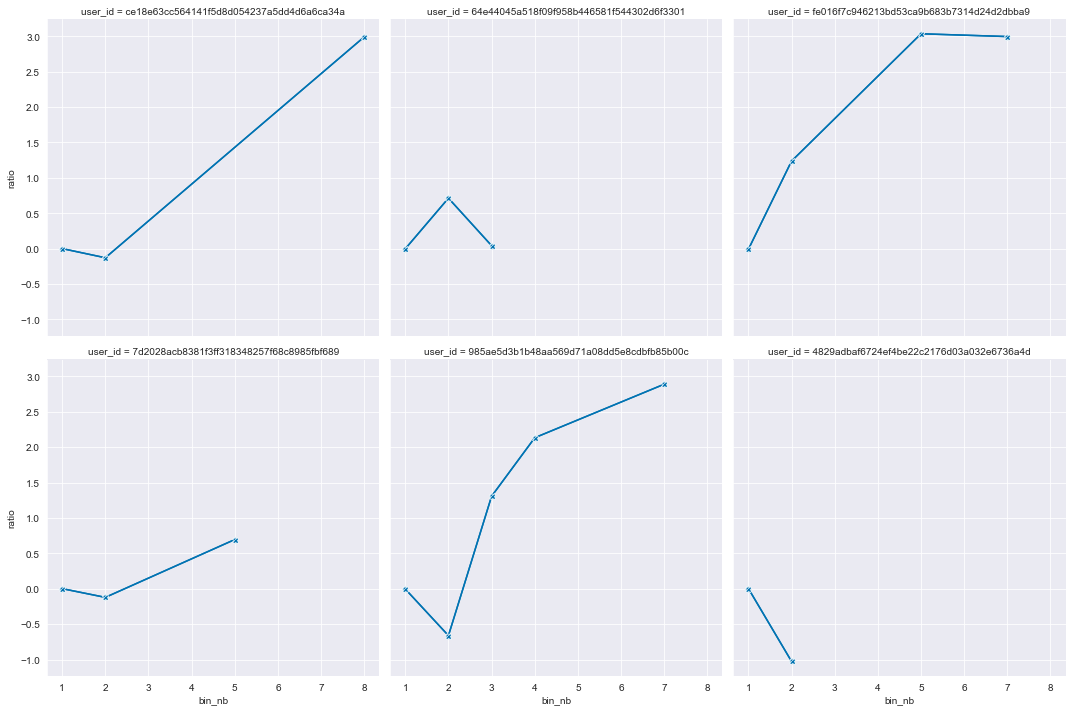

In [92]:
if not SEPARATE_RECO:
    sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
                estimator=None, data=aggregate, legend=False, style="recommended")
else:
    sns.relplot(x="bin_nb", y="ratio", hue="recommended", style="recommended", kind="line", col="user_id",
                col_wrap=3, dashes=False, markers=True, estimator=None, data=aggregate, legend="brief")
sns.despine()
plt.show()